<a href="https://colab.research.google.com/github/Vixuz144/Simu2/blob/main/Robin_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulación

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas polares.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

2. En adición, las funcioness de distribución de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$



3. Y las funciones de distribución acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles. Para lo cual haremos uso de la siguiente función.

In [254]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit

In [255]:
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(r*random())
    i += 1

  X = R*np.cos(θ)
  Y = R*np.sin(θ)
  return X, Y

Esta función genera el proceso de Poisson bivariado.

* Entradas:
  * r: Radio del circulo dentro del cual se generarán los arboles. Debe ser positivo.
  * ρ: Parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser positivo.


* Salidas:
  * X: Lista con las abscisas de las coordenadas de los arboles.
  * Y: Lista con las ordenadas de las coordenadas de los arboles.

4. Ahora, veamos la ejecución de la función. Para ello consideraremos un radio de $100m$ y una densidad de $0.005\frac{árboles}{m^2}$ para nuestra simulación.

In [256]:
radio = 100
densidad = 0.005

In [257]:
X, Y = bosque(radio, densidad)

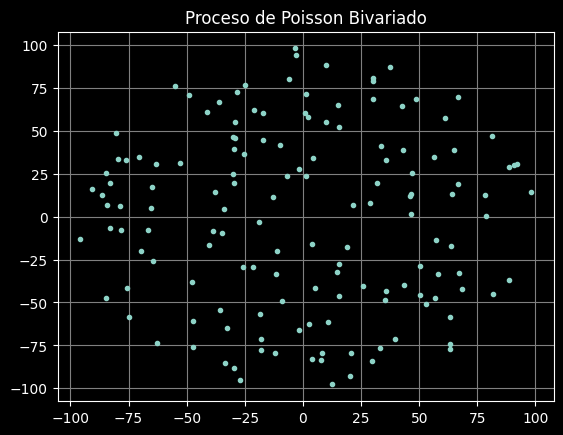

In [258]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Proceso de Poisson Bivariado')
plt.grid(color='gray')
plt.show()

5. Implementación del arquero, Robin Hood.

Para esste punto, ya tenemos la una pequeña parte de nuestra simulación armada. Ahora, vamos a agregar a nuestro coprotagonista del problema, Robin Hood. Para ello vamos a considerar que este famoso arquero se localiza en el centro de nuestro bosque de Sherwood. Y al lanzar una flecha en una dirección (cartesiana) aleatoria podrá impactarse y quedar fija en algún arbol. Ahora la dilemática está en ¿Cómo sabremos que la flecha queda incrustada o no en el árbol?.

Para ello tendremos que saber que dimensiones tiene el arbol. Para lo cual consideremos de momento que el tronco del arbol es un cilindro de radio $r_a$. Con lo cual si la dirección de la flecha se intersecta con una circunferencia de radio $r_a$ con centro en las cordenadas de un árbol, habrá impactado con el árbol y diremos que ahí fue donde terminó la fleca tras el lanzamiento.

Para programar esto, haremos uso de pequeños trucos Para ahorrar recursos computacionales.
* Primero, en lugar de disparar una flecha en una dirección aleatoria vamos a dispararla en la dirección del eje positivo $x$, es decir, con dirección $(1, 0)$. esto ya que al generar un bosque aleatorio cada vez, será como haber elegido una dirección por la misma pseudo-aleatoriedad del proceso de Poisson.
* Con ésta implementación ahora solo queda decidir cuando la flecha ha impactado con el arbol. Para lo cual descartaremos todos los arboles que tengan coordenadas negativas en su abscisa. Ya que no podrá llegar la flecha en esa dirección a menos que rebote.
* Luego, en lugar de calcular la circunferencia de cada uno de los árboles, unicamente comprobaremos si la flecha pasa sí suficientemente cerca de los árboles. Para ello compararemos el radio de cada árbol en la media circunferencia con la distancia que hay del centro del árbol (coordenadas generadas por el proceso de Poisson) a la flecha, de manera que si la distancia es menor al radio la flecha habrá impactado, y en caso de que la distancia sea mayor al radio la flecha no habrá impactado.
* Y el truquito final será como calcular la distancia del centro del árbol a la flecha, el cual será fácil gracias a tomar la dirección de la flecha como el eje $x$ positivo. Ya que se despreciará la coordenada en $x$ del árbol y de la flecha, resultando en que la distancia será el valor absoluto de la coordenada en $y$ del árbol.

Lo único que resta antes de codificar estos trucos será considerar que la flecha se detiene cuando impacte el primer árbol. Por lo cual Robin deberá ir por su fleha hasta ese árbol en caso de querer recuperarla.

In [259]:
def disparo_flecha(abscisas, ordenadas, r):
  X, Y = np.array(abscisas), np.array(ordenadas)
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos = X[pos], Y[pos]

  s = np.argsort(X_pos)
  X, Y = X_pos[s], Y_pos[s]
  n = len(Y)

  x, y = 0, 0
  for i in range(n):
    if abs(Y[i]) < r:
      x, y = X[i], Y[i]
      break

  d = np.sqrt(r**2 - y**2)
  return x, y, d

La flecha impactó en el arbol con coordenadas (78.5385091158025,0.18847985743825416). La flecha recorrió 0.9820770557039072m


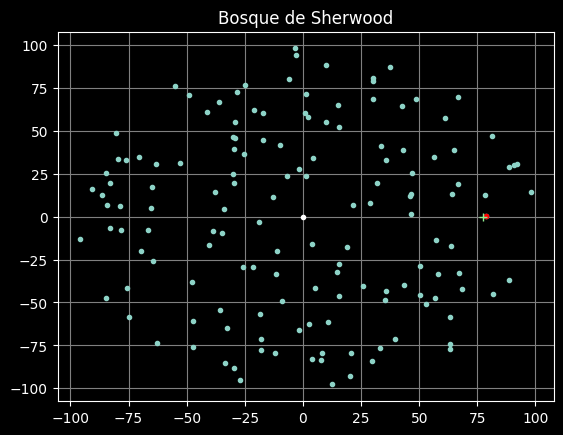

In [266]:
r = 1
x, y, d = disparo_flecha(X, Y, r)

print(f'La flecha impactó en el arbol con coordenadas ({x},{y}). La flecha recorrió {d}m')

plt.plot(X, Y, '.')
plt.plot(0, 0, '.w')
plt.plot(x, y, '.r')
plt.plot(x-d, 0, '+', color = 'lightgreen')
plt.title('Bosque de Sherwood')
plt.grid(color='gray')
plt.show()

6. Ahora, veamos como se comporta esta simulación. Para ello, se repetirá la anterior sumulación una gran cantidad de veces. Para ello haremos uso de la siguiente función.

In [261]:
# def rep